# Post-processing examples

In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
from napari_meristem import postproc
import numpy as np
from anytree import Node, RenderTree
from anytree.render import AsciiStyle, ContStyle
import pandas as pd
import matplotlib.pyplot as plt
from napari_meristem import postproc



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.10.18 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




First run the interactive plugins to (1) stitch the FOVs, (2) register the time points, (3) segment cells, (4) Manually track complexes of interest. All the data should now be available in an `export_folder` containing stack data and folders with information about tracked complexes.

**Set the ```export_folder``` and whether to use the manually fixed data or not**:

In [2]:
# set export folder
export_folder = '/Users/gw18g940/Desktop/Test_data/Raissig/Kalanchoëdata/test_export_stack1'

# use manually fixed data
manual = True

## Compute properties

In this section the data are loaded and properties of cells computed. No user interaction needed:

In [3]:
complex_list = postproc.get_complexes_path(export_folder)

if manual:
    prefix = 'manual_'
else:
    prefix = ''

# compute props for ALL segmented data
mask_stitched, props = postproc.get_stack_props(
    export_folder, stack_type='stitched', prefix=prefix)

## Load information

The following list of complexes was found:

In [4]:
for ind, c in enumerate(complex_list):
    print(f'index {ind}: {c.name}')

index 0: complex_0
index 1: complex_1
index 2: complex_2
index 3: complex_3
index 4: complex_4


Here we load the track information for a given complex, add relevant information to the tracks, such as the area (needs to be in the props) and creates a tree structure. The latter can incorporate properties that have been added to the track. First pick an index:

In [5]:
complex_id = 2

In [6]:
current_track, graph = postproc.load_complex_track(complex_list[complex_id])
current_track = postproc.add_feature_to_track(current_track, props, 'area')

all_trees = postproc.create_cell_tree(current_track, graph, properties=['t', 'area'])

```current_track``` is a DataFrame where each line is a point of track. The various tracks are identified using ```track_id```, ```txy```, locate the cell, ```label``` is the mask label of the cells at that ```txy```, ```identity``` is an optional feature that can indicate the type of cell and area is the size of the cell at that ```txy```:

In [7]:
current_track.head(5)

,track_id,t,y,x,label,identity,area
0,0,0,816,773,475,NaN,391.0
1,0,1,816,767,479,NaN,454.0
2,1,2,816,761,441,NaN,306.0
3,1,3,818,773,380,NaN,386.0
4,1,4,822,771,336,NaN,512.0


```graph``` shows mother-daugher relationships beteween tracks:

In [8]:
graph

,id,mother_id
0,1,0
1,2,0
2,3,2
3,4,2
4,5,4
5,6,4


```all_trees``` represents the cell tree. It is a dictionary where each key is a cell and each entry is a ```Node``` object containing: 
- mother-daughers relation
- identity
- track_id
- props, a 2D array of time-area: ```[[t0, area at t0], [t1, area at t1], ...]```

In [9]:
all_trees

{'cell_0': Node('/cell_0', identity=nan, props=array([[  0., 391.],
        [  1., 454.]]), track_id=np.int64(0)),
 'cell_1': Node('/cell_0/cell_1', identity=nan, props=array([[   2.,  306.],
        [   3.,  386.],
        [   4.,  512.],
        [   5.,  594.],
        [   6.,  736.],
        [   7.,  899.],
        [   8., 1099.],
        [   9., 1283.]]), track_id=1),
 'cell_2': Node('/cell_0/cell_2', identity=nan, props=array([[  2., 195.],
        [  3., 276.]]), track_id=2),
 'cell_3': Node('/cell_0/cell_2/cell_3', identity=nan, props=array([[  4., 224.],
        [  5., 299.],
        [  6., 361.],
        [  7., 461.],
        [  8., 584.],
        [  9., 734.]]), track_id=3),
 'cell_4': Node('/cell_0/cell_2/cell_4', identity=nan, props=array([[  4., 202.],
        [  5., 277.],
        [  6., 383.]]), track_id=4),
 'cell_5': Node('/cell_0/cell_2/cell_4/cell_5', identity='guard', props=array([[  7., 265.],
        [  8., 419.],
        [  9., 612.]]), track_id=5),
 'cell_6': No

The tree can be displayed:

In [10]:
postproc.display_tree(all_trees)

cell_0 nan
├── cell_1 nan
└── cell_2 nan
    ├── cell_3 nan
    └── cell_4 nan
        ├── cell_5 guard
        └── cell_6 nan


The above code is summarized in the function ```load_complex_data```:

In [11]:
complex_list, current_track, graph, all_trees = postproc.load_complex_data(
    export_folder=export_folder, complex_id=complex_id, props=props, properties=('area'))

As an example of the type of data that can be extracted, we show here ```get_division_event```, which, given an ```all_tree``` info, return for each division event the cell id and division time:

In [12]:
division_events = postproc.get_division_event(all_trees)
num_origins, origin_cells = postproc.get_origin_cells(all_trees)

In [13]:
division_events

[{'id': 'cell_0', 'div_t': np.float64(1.0)},
 {'id': 'cell_2', 'div_t': np.float64(3.0)},
 {'id': 'cell_4', 'div_t': np.float64(6.0)}]

Here we can see e.g. that ```cell_2``` divided at ```t=3```.

## Following divisions of specific cell cell

Here we show how to follow the fate of cells. First we define the name of the cell to track:

In [18]:
cell_identity = 'guard'

Then we load the data in a clean way:

In [17]:
complex_id = 2
complex_list, current_track, graph, all_trees = postproc.load_complex_data(
    export_folder=export_folder, complex_id=complex_id, props=props, properties=('area'))

When processing the data, it's possible to give an identity to a cell only at the last genereation. But one may want to know the IDs of all cells that lead to that cell. For a cell with a given **identity** cell this can be done with ```guard_genealogy``` (the function is called like that but can be used with any identity):

In [19]:
guard_tree = postproc.guard_genealogy(all_trees, cell_name=cell_identity)
guard_tree

array([0, 2, 4, 5])

Using the information of ```all_trees``` and ```guard_tree``` we can extract arbitrary information. For example the area over time for the guard cells:

In [20]:
area_time = []
for g in guard_tree:
    area_time.append(all_trees[f'cell_{g}'].props)

area_time = np.concat(area_time)

In [21]:
area_time

array([[  0., 391.],
       [  1., 454.],
       [  2., 195.],
       [  3., 276.],
       [  4., 202.],
       [  5., 277.],
       [  6., 383.],
       [  7., 265.],
       [  8., 419.],
       [  9., 612.]])

We can also traverse the whole `all_trees` and plot area vs time, checking if a current track belong to the guard tree or not:

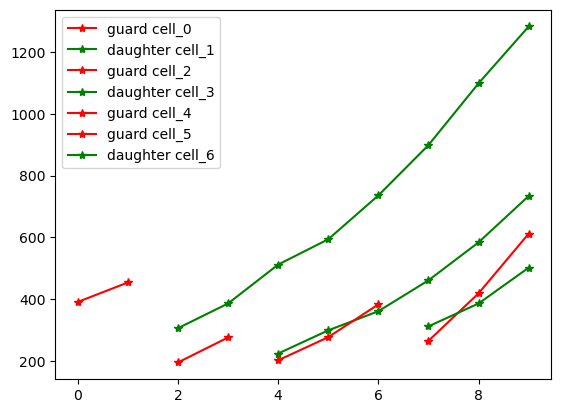

In [22]:
symbols = ['*','-','o','x', 'd']
fig, ax = plt.subplots()
ind = 0
for key,val in all_trees.items():
    if val.is_root:

        if val.track_id in guard_tree:
                ax.plot(val.props[:,0], val.props[:,1], f'r{symbols[ind%5]}-', label=f'{cell_identity} {val.name}')
        else:
            ax.plot(val.props[:,0], val.props[:,1], f'g{symbols[ind%5]}-', label=f'daughter {val.name}')
                
        for tr in val.descendants:
            if tr.track_id in guard_tree:
                ax.plot(tr.props[:,0], tr.props[:,1], f'r{symbols[ind%5]}-', label=f'{cell_identity} {tr.name}')
            else:
                ax.plot(tr.props[:,0], tr.props[:,1], f'g{symbols[ind%5]}-', label=f'daughter {tr.name}')
        ind+=1
ax.legend(); 


## Size up to division

We have seen above that we could recover division events. We can follow tracks of cells and check for the total size up to division:

In [23]:
complex_id = 4
complex_list, current_track, graph, all_trees = postproc.load_complex_data(
    export_folder=export_folder, complex_id=complex_id, props=props, properties=('area'))

In [24]:
postproc.display_tree(all_trees)

cell_0 guard
cell_1 nan
cell_2 nan
cell_3 nan
├── cell_4 nan
└── cell_5 nan


In [25]:
division_events = postproc.get_division_event(all_trees)
division_events

[{'id': 'cell_3', 'div_t': np.float64(3.0)}]

In [26]:
# sum cell area up to division
include_guard = True

all_props = []
for k in all_trees.keys():
    if not include_guard:
        if all_trees[k].identity == 'guard':
            continue
    cur_props = all_trees[k].props
    #recover data pre-division
    cur_props = cur_props[cur_props[:,0] <= division_events[0]['div_t']]
    all_props.append(cur_props)
all_props = pd.DataFrame(np.concat(all_props, axis=0), columns=('t','area'))

The ```all_props``` DataFrame contains area size for all cells up to division (id is discarded here):

In [27]:
all_props

,t,area
0,0.0,544.0
1,1.0,764.0
2,2.0,1570.0
3,3.0,1966.0
4,0.0,501.0
5,1.0,596.0
6,2.0,581.0
7,3.0,739.0
8,0.0,704.0
9,1.0,850.0


We can now sum up the values by `t` to get the full complex size across time, up to division:

In [28]:
sum_area_t = all_props.groupby('t').sum().reset_index()

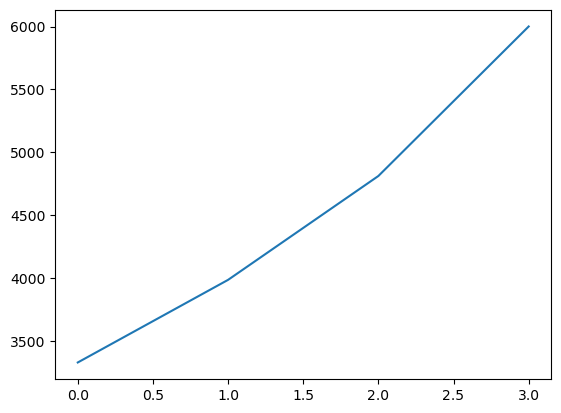

In [29]:
plt.plot(sum_area_t.t, sum_area_t.area);

# Angle between divisions

In case of multiple divisions leading to guard cell, we can track the angle between divisions:

In [30]:
complex_id = 2
complex_list, current_track, graph, all_trees = postproc.load_complex_data(
    export_folder=export_folder, complex_id=complex_id, props=props, properties=('area'))
guard_tree = postproc.guard_genealogy(all_trees, cell_name=cell_identity)
guard_tree

array([0, 2, 4, 5])

In [31]:
# add coordinates to tracks
current_track = postproc.add_feature_to_track(current_track, props, 'coords')

Here we measure the division orientation by fitting a line to the division region:

In [32]:
slopes = []
for g in guard_tree:
    pair = graph[graph.mother_id == g]

    if len(pair) == 2:
        slope = postproc.division_orientation(current_track, props,  pair.id.values[0], pair.id.values[1], im_dims=mask_stitched.shape[1::])
        slopes.append(slope)

In [33]:
angles = []
for i in range(len(slopes)-1):
    angle = np.arctan((slopes[i+1]-slopes[i])/(1+slopes[i+1]*slopes[i]))
    angles.append(np.rad2deg(angle))

In [34]:
angles

[np.float64(58.74036246181386), np.float64(53.54706264570526)]

## Display divisions

For visualization purposes we can align the movie of a complex on the guard cells. For this we need the additional information of the cell coordinates:

In [35]:
guard_tree_track = current_track[current_track.track_id.apply(lambda x: x in guard_tree)]
guard_tree_track = guard_tree_track.set_index('t')
guard_tree_track['mean_coord'] = guard_tree_track.coords.apply(lambda x: np.mean(x, axis=0).astype(np.uint16))

In [36]:
# center all coordinates with respect to guard cell
centered_coords = []
for i in current_track.index:
    centered_coords.append(current_track.loc[i,'coords'] - guard_tree_track.loc[current_track.iloc[i,:]['t'],'mean_coord'])
current_track['centered_coord'] = centered_coords

In [37]:
# create an image with new coordinates
image = np.zeros((mask_stitched.shape[0], 200, 200), dtype=np.uint8)
for t in np.unique(current_track.t):
    table_t = current_track[current_track.t == t]
    for ind, tt in table_t.iterrows():
        image[t][tt.centered_coord[:,0] + 100, tt.centered_coord[:,1]+100] = tt.track_id


In [38]:
import napari
viewer = napari.Viewer()
viewer.add_labels(image)

<Labels layer 'image' at 0x35b9cd600>